In [1]:
#%pip install tensorflow

In [2]:
#%pip install --upgrade tensorflow-hub

In [3]:
#%pip install torch torchvision

In [4]:
#%pip install segment-geospatial groundingdino-py leafmap localtileserver

In [1]:
import os
import numpy as np
import cv2
import glob as glob
import json

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import warnings
import logging
import absl

from random import randint
from torchvision import transforms

from samgeo.text_sam import LangSAM

# Filter absl warnings
warnings.filterwarnings("ignore", module="absl")

# Capture all warnings in the logging system
logging.captureWarnings(True)

# Set the absl logger level to 'error' to suppress warnings
absl_logger = logging.getLogger("absl")
absl_logger.setLevel(logging.ERROR)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### 1.1 Display Sample Images

In [57]:
from PIL import Image 
 
png_folder = r'18_vegetation_switch_18.1/rgb_center/'
# Use the os.listdir function to list the files in the folder 
image_files = os.listdir(png_folder)



In [58]:
len(image_files)

10

In [59]:
image_files

['076_1631625168.700000040.png',
 '077_1631625168.800000040.png',
 '078_1631625168.900000040.png',
 '079_1631625169.000000040.png',
 '080_1631625169.100000040.png',
 '081_1631625169.200000040.png',
 '082_1631625169.300000040.png',
 '083_1631625169.400000040.png',
 '084_1631625169.500000040.png',
 '085_1631625169.600000040.png']

## Model - Language Segment-Anything

Language Segment-Anything is an open-source project that combines the power of instance segmentation and text prompts to generate masks for specific objects in images. Built on the recently released Meta model, segment-anything, and the GroundingDINO detection model, it's an easy-to-use and effective tool for object detection and image segmentation.

In [96]:
sam = LangSAM()
text_prompt = "vegetation"

final text_encoder_type: bert-base-uncased


In [99]:
png_folder = r'20_vegetation_squirrel_20.1/rgb_center/'
# Use the os.listdir function to list the files in the folder 
image_files = os.listdir(png_folder)


In [98]:
box_threshold=0.24
text_threshold=0.3

In [100]:
iou_ls = []
im_jpg_ls = []
im_id_map_ls = []
total_mask_ls = []
ground_mask_veg_ls = []
sam_mask_veg_ls = []
counter = 0

for i in image_files:
    image_path = png_folder + i

    print("Processing image:", image_path)

    im_jpg = cv2.imread(image_path)
    print("im_jpg shape:", im_jpg.shape)

    image_pil = Image.open(image_path).convert("RGB")

    sam.predict(image_pil, text_prompt, box_threshold=box_threshold, text_threshold=text_threshold)

    masks = sam.masks

    total_mask = tf.zeros_like(masks[0], dtype=tf.uint8)

    for mask in masks:
        total_mask = tf.math.maximum(total_mask, mask)

    sam_mask_veg = np.where(np.isin(total_mask, [1]), 1, 0)
    print("sam_mask_veg shape:", sam_mask_veg.shape)

    im = Image.fromarray(sam_mask_veg)
    # Define the transformation
    transform = transforms.ToTensor()

    # Apply the transformation to convert PIL Image to PyTorch Tensor
    tensor_img = transform(im)

    im_jpg_ls.append(im_jpg)
    total_mask_ls.append(total_mask)
    sam_mask_veg_ls.append(sam_mask_veg)

    counter += 1

    if counter == 5:
        break

# Print the lengths of the lists
print("Length of im_jpg_ls:", len(im_jpg_ls))
print("Length of total_mask_ls:", len(total_mask_ls))
print("Length of sam_mask_veg_ls:", len(sam_mask_veg_ls))


Processing image: 20_vegetation_squirrel_20.1/rgb_center/000_1631716528.100000008.png
im_jpg shape: (1600, 2464, 3)
sam_mask_veg shape: (1600, 2464)
Processing image: 20_vegetation_squirrel_20.1/rgb_center/001_1631716528.200000008.png
im_jpg shape: (1600, 2464, 3)
sam_mask_veg shape: (1600, 2464)
Processing image: 20_vegetation_squirrel_20.1/rgb_center/002_1631716528.300000008.png
im_jpg shape: (1600, 2464, 3)
sam_mask_veg shape: (1600, 2464)
Processing image: 20_vegetation_squirrel_20.1/rgb_center/003_1631716528.400000008.png
im_jpg shape: (1600, 2464, 3)
sam_mask_veg shape: (1600, 2464)
Processing image: 20_vegetation_squirrel_20.1/rgb_center/004_1631716528.500000008.png
im_jpg shape: (1600, 2464, 3)
sam_mask_veg shape: (1600, 2464)
Length of im_jpg_ls: 5
Length of total_mask_ls: 5
Length of sam_mask_veg_ls: 5


In [93]:
inp_path_config_json = r"C:\Users\AylinGülüm\OneDrive - Hochschule für Technik und Wirtschaft Berlin\Desktop\PM Lab\rs19_val\rs19-config.json"
class_index = json.load(open(inp_path_config_json, 'r'))

In [94]:
def config_to_rgb(inp_path_config_json, default_col = [255,255,255]):
    lut = []
    inp_json = json.load(open(inp_path_config_json, 'r'))
    for c in range(3): #for each color channel
        lut_c =[l["color"][c] for l in inp_json["labels"]]+[default_col[c]]*(256-len(inp_json["labels"]))
        lut.append(np.asarray(lut_c, dtype=np.uint8))
    return lut

lut_bgr = config_to_rgb(inp_path_config_json, default_col = [255,255,255])[::-1] 

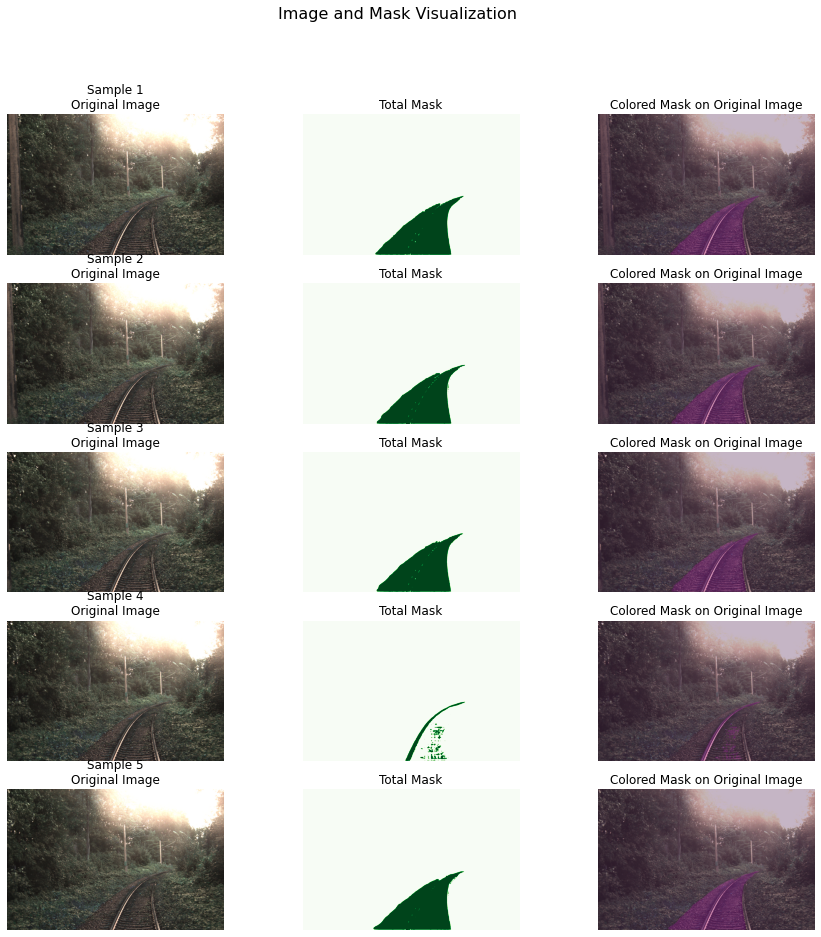

In [101]:
# Function to colorize the mask and map it to the original image
def get_joined_img(im_jpg, total_mask, lut_bgr, blend_vals=[0.65,0.25,0.1]):
    total_mask = np.where(total_mask == 1, 1, total_mask)
    im_id_col = np.zeros((total_mask.shape[0], total_mask.shape[1], 3), np.uint8)
    
    for c in range(3):
        im_id_col[:,:,c] = lut_bgr[c][total_mask] #apply color coding
    return (im_jpg*blend_vals[0]+im_id_col*blend_vals[1]).astype(np.uint8) #blend all three data sources


def visualize_pilots(im_jpg_ls, total_mask_ls):
    num_samples = len(im_jpg_ls)

    if num_samples == 0:
        print("No samples to visualize.")
        return

    # Set the number of columns for subplots
    num_cols = 3

    # Adjust the number of rows to be at least 1
    num_rows = max(1, num_samples)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    fig.suptitle("Image and Mask Visualization", fontsize=16)

    for i in range(num_samples):
        axs[i, 0].imshow(im_jpg_ls[i])
        axs[i, 0].set_title(f"Sample {i + 1}\nOriginal Image")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(total_mask_ls[i].numpy(), cmap="Greens")
        axs[i, 1].set_title("Total Mask")
        axs[i, 1].axis("off")

        sam_mask = get_joined_img(im_jpg_ls[i], total_mask_ls[i], lut_bgr, blend_vals=[0.65,0.25,0.1])
        axs[i, 2].imshow(sam_mask)
        axs[i, 2].set_title("Colored Mask on Original Image")
        axs[i, 2].axis("off")

    plt.show()

# Call the function with your lists
visualize_pilots(im_jpg_ls, total_mask_ls)
